# Quickstart

Here, we'll go through a very basic example of reconstructing, preprocessing, and visualizing 4D faces from video data using Medusa's Python API. For more information about its command-line interface, check the CLI [documentation](../api/cli)!

We'll use a short video to reconstruct, shown below:

In [3]:
import os  # need 'egl' for 'headless' rendering!
os.environ['PYOPENGL_PLATFORM'] = 'egl'
from IPython.display import Video

from medusa.data import get_example_video
vid = get_example_video()

# Show in notebook
#Video(vid, embed=True)  

## Reconstruction

For this example, we'll use the [Mediapipe Face Mesh](https://google.github.io/mediapipe/solutions/face_mesh.html) model to reconstruct the face in the video in 4D, that is, a 3D reconstruction for each frame of the video. We are going to use the high-level `videorecon` function from Medusa, which reconstructs the video frame by frame and returns a ``Data4D`` object, which contains all reconstruction (meta)data.

In [2]:
from medusa.recon import videorecon
data = videorecon(vid, recon_model='mediapipe', loglevel='WARNING')

2022-12-21 15:38 [INFO   ]  Recon images: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]


Great! Now let's inspect the ``data`` variable. The reconstructed vertices are stored in the attribute `v`, a [torch](https://pytorch.org/) tensor of shape $T$ (time points) $\times\ V$ (vertices) $\times\ 3$ (X, Y, Z).

In [6]:
print("`v` is of type: ", type(data.v))
print("`v` has shape: ", tuple(data.v.shape))

`v` is of type:  <class 'torch.Tensor'>
`v` has shape:  (232, 468, 3)


The the data contained in `v` represents, for each time point, the 3D coordinates of the vertices (also called "landmarks") that describe the shape of the face. The particular mesh used by Mediapipe contains 468 vertices, but other reconstruction models may contain many more vertices (like [FLAME](https://flame.is.tue.mpg.de)-based models, which reconstruct 5023 vertices)!

To get an idea of the data, let's just extract the 3D vertices from the first time point (i.e., the first frame of the video) and plot it. We need to do this in 2D, of course, so we'll just a scatterplot to visualize the X and Y coordinates only:  

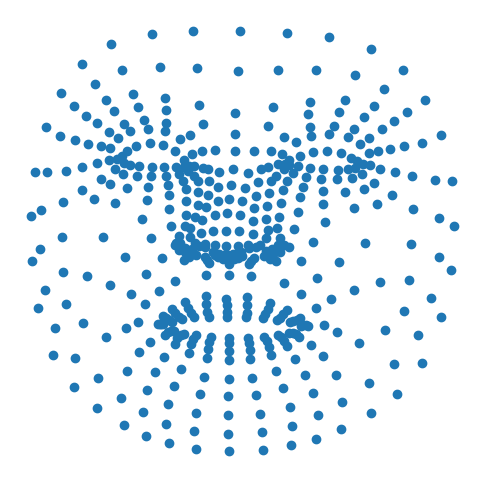

In [7]:
import matplotlib.pyplot as plt
v = data.v.cpu().numpy()  # to numpy!
t0 = v[0, :, :]  # first time point
t0_x = t0[:, 0]
t0_y = t0[:, 1]

plt.figure(figsize=(6, 6))
plt.scatter(t0_x, t0_y)
plt.axis('off')
plt.show()

A more appealing way to visualize the reconstruction is as a "wireframe". Medusa allows you to do this for all time points, such that it creates a video of the full 4D reconstruction, and (optionally) rendered on top of the original video as well. To do so, you can use the ``render_video`` method that each data object in Medusa has. 

We do this below. By setting the `video` parameter to the path of the video, we tell the `render_video` method to render the wireframe on top of the original video:

In [8]:
f_out = './example_vid_recon.mp4'
data.render_video(f_out, shading='wireframe', video=vid)

# Show in notebook
#Video('./example_vid_recon.mp4', embed=True)

2022-12-21 15:43 [INFO   ]  Render shape: 100%|██████████| 232/232 [00:04<00:00, 56.97it/s]


That looks pretty good! However, there are two issues with the data as it is now. First, each vertex represents both "global" (rigid) movement (i.e., the face moving left/right/up/down and rotating) and "local" (non-rigid) information (i.e., facial expressions such as smiling and frowning). Second, part of these rigid movements seem to reflect noisy "jitter", which are simply inaccuracies in the reconstruction.

## Alignment

We can separate global and local movement by *aligning* the reconstructions across time. Alignment, here, refers to the rotation and translation necessary to match the reconstructed vertices from each timepoint to a reference timepoint or template. To align a reconstructed 4D dataset, you can use the `align` function:

In [6]:
from medusa.preproc import align
data = align(data)

AttributeError: 'Data4D' object has no attribute 'recon_model'

After alignment, the vertices now represent local movement only (as the global movement has been projected out). Let's visualize the data again, to confirm that it only represents local movement:

In [ ]:
f_out = './example_vid_recon.mp4'
data.render_video(f_out, wireframe=True, video=vid)

Video('./example_vid_recon.mp4', embed=True)

As you can see, the rotation (e.g., head tilt) and translation (moving sideways) has been projected out of the data! Importantly, after alignment, the alignment parameters are stored as a series of $4 \times 4$ affine matrices (one for each timepoint) in the attribute `mat`:

In [10]:
# T (timepoints) x 4 x 4
print("Shape of .mat attribute: ", tuple(data.mat.shape))

Shape of .mat attribute:  (232, 4, 4)


We can convert this matrix representation to a set of translation and rotation parameters (and shear and scale parameters, which we ignore for now) that are easier to interpret. To do this, you can use the `decompose_mats` method:

In [11]:
# Decompose affine matrices to movement parameters
motion_params = data.decompose_mats()

# Select translation and rotation only (ignore shear/scale)
motion_params = motion_params.iloc[:, :6]

# Show first five timepoints
motion_params.head()

,Trans. X,Trans. Y,Trans. Z,Rot. X (deg),Rot. Y (deg),Rot. Z (deg)
0,3.684671,-0.050394,-31.705336,-6.338448,1.457200,-0.993545
1,3.720133,-0.142583,-31.516129,-7.274602,1.364909,-1.227495
2,3.787872,-0.142521,-31.566744,-7.358114,1.189006,-1.086345
3,3.833373,-0.172675,-31.584751,-7.505661,1.723046,-1.011539
4,3.874373,-0.181334,-31.600647,-7.625006,1.532982,-1.082351


Just like the vertices, these parameters can be interpreted as timeseries representing the rigid movement of the face over time:

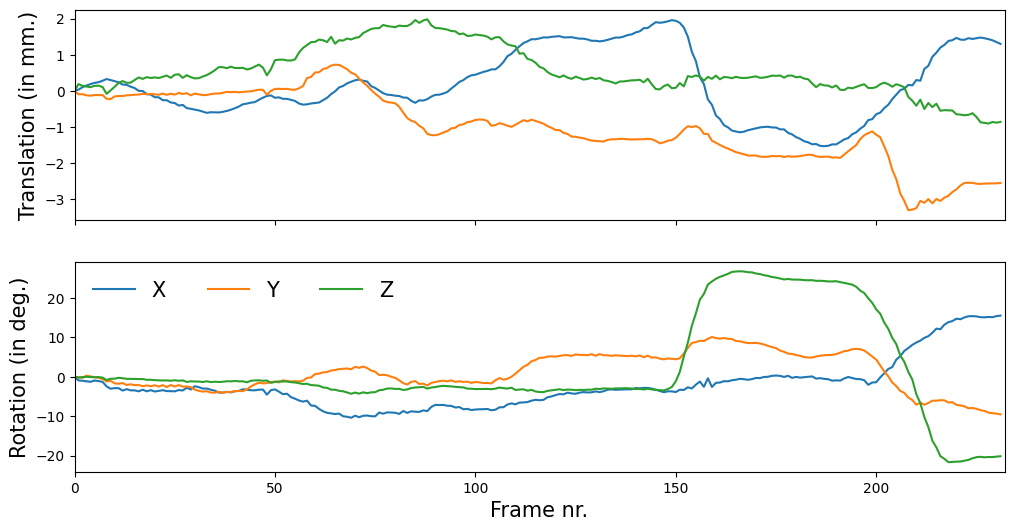

In [12]:
# Show movement relative to first timepoint
motion_params = motion_params - motion_params.iloc[0, :]
trans_params = motion_params.iloc[:, :3]
rot_params = motion_params.iloc[:, 3:]

fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(12, 6))
axes[0].plot(trans_params)
axes[0].set_ylabel('Translation (in mm.)', fontsize=15)
axes[0].set_xlim(0, motion_params.shape[0])
axes[1].plot(rot_params)
axes[1].set_ylabel('Rotation (in deg.)', fontsize=15)
axes[1].set_xlabel('Frame nr.', fontsize=15)
axes[1].legend(['X', 'Y', 'Z'], frameon=False, ncol=3, fontsize=15)
fig.show()

## Temporal preprocessing

Medusa contains several functions to further preprocess the 4D data. One functionality to highlight is temporal filtering, which you can use to filter out low and high-frequency noise, such as the "jitter" we observer earlier. The `bw_filter` ("butterworth filter") implements a band-pass filter to do just this:

In [ ]:
from medusa.preproc import bw_filter

# cut-off frequencies in Herz
data = bw_filter(data, low_pass=4, high_pass=0.005)

Let's render the data again, which should now look a lot "smoother":

In [ ]:
f_out = './example_vid_recon.mp4'
data.render_video(f_out, wireframe=True, video=None)

Video('./example_vid_recon.mp4', embed=True)

There is a lot more functionality in Medusa, including different reconstruction models, additional preprocessing functions, and analysis options. A great way to explore this is to check out the tutorials!